In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy import spatial
from astropy.table import Table
from astropy.cosmology import LambdaCDM as Cos
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from IPython import display 
from scipy import stats
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit, optimize, minimize_scalar, root
import fitsio
from sklearn.neighbors import NearestNeighbors
from scipy.special import gammaincc
import pickle
import dask
import os

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 10)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:46221 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 20 Memory: 67.31 GB


In [3]:
table_of_centers = pd.read_csv("list_of_sweeps.csv")

In [4]:
table_of_centers.patch[10][71:]

'/sweep-030m020-040m015.fits'

In [5]:
table_of_centers.photoz[10][79:]

'/sweep-030m020-040m015-pz.fits'

In [6]:
table_of_centers.masses[10][70:]

'/sweep-030m020-040m015_stellar_mass.npy'

In [7]:
for i in range(0, len(table_of_centers)):
    table_of_centers.at[i, "patch"] = '/data/mjb299/sweep' + table_of_centers.iloc[i].patch[71:]
    table_of_centers.at[i, "photoz"] = '/data/mjb299/photoz' + table_of_centers.iloc[i].photoz[79:]
    table_of_centers.at[i, "masses"] = '/data/mjb299/mass' + table_of_centers.iloc[i].masses[70:]

In [8]:
def data_import(maxx, maxy, minx, miny, row2):
    fits_data = fitsio.FITS(row2.patch)
    sweep = fits_data[1].read(columns=['RELEASE','BRICKID','BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'MASKBITS', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE'])
    data = Table.read(row2.photoz, format = "fits")
    pz = data.to_pandas()
    #with fits.open(row2.photoz) as data:
    #    pz = pd.DataFrame(data[1].data)
    mass = np.load(row2.masses)
    
    pz['mass'] = mass
    pz['RELEASE']=sweep['RELEASE']
    pz['BRICKID']=sweep['BRICKID']
    pz['BRICKNAME']=sweep['BRICKNAME']
    pz['OBJID']=sweep['OBJID']
    pz['TYPE']=sweep['TYPE']
    pz['RA']=sweep['RA']
    pz['DEC']=sweep['DEC']
    pz['FLUX_G']=sweep['FLUX_G']
    pz['FLUX_R']=sweep['FLUX_R']
    pz['FLUX_Z']=sweep['FLUX_Z']
    pz['FLUX_W1']=sweep['FLUX_W1']
    pz['MASKBITS']=sweep['MASKBITS']
    pz['gaia_phot_g_mean_mag']=sweep['GAIA_PHOT_G_MEAN_MAG']
    pz['gaia_astrometric_excess_noise']=sweep['GAIA_ASTROMETRIC_EXCESS_NOISE']
    pz = pz[np.logical_and.reduce((pz.RA < maxx + buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC < maxy + buffer, pz.RA > minx - buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC > miny - buffer))]
    return pz

@dask.delayed()
def data_importer(row):
    fits_data = fitsio.FITS(row.patch)
    sweep = fits_data[1].read(columns=['RA', 'DEC'])
    maxx = max(sweep['RA'])
    maxy = max(sweep['DEC'])
    minx = min(sweep['RA'])
    miny = min(sweep['DEC'])

    maxRA = max(sweep['RA'])
    maxDEC = max(sweep['DEC'])
    minRA = min(sweep['RA'])
    minDEC = min(sweep['DEC'])

    ra_dec = data_import(maxx, maxy, minx, miny, row)
    #Initial sample cuts
    zmag=np.array(22.5-2.5*np.log10(ra_dec.FLUX_Z))
    zmag[np.where(~np.isfinite(zmag))]=99.
    #whgood=np.where(np.logical_and(zmag < 21,ra_dec.mass > 0 ))
    isgood=np.logical_and(zmag < 21,ra_dec.mass > 0)
    ra_dec = ra_dec[isgood]

    #Further sample cuts
    ra_dec = ra_dec[np.logical_or(ra_dec.MASKBITS == 0, ra_dec.MASKBITS == 4096)]
    ra_dec = ra_dec[np.logical_or(np.logical_or(ra_dec.gaia_phot_g_mean_mag > 19, ra_dec.gaia_astrometric_excess_noise > 10**.5), ra_dec.gaia_astrometric_excess_noise==0)]
    ra_dec["magR"] = 22.5-2.5*np.log10(ra_dec.FLUX_R)
    ra_dec["magZ"] = 22.5-2.5*np.log10(ra_dec.FLUX_Z)
    ra_dec["magW1"] = 22.5-2.5*np.log10(ra_dec.FLUX_W1)
    l_mask = (ra_dec.magR - ra_dec.magW1) > 1.8*(ra_dec.magR-ra_dec.magZ)-0.6
    l_mask[~np.isfinite(l_mask)] = False
    ra_dec = ra_dec[np.logical_and(22.5 - 2.5*np.log10(ra_dec.FLUX_Z)<21, ra_dec.Z_PHOT_MEDIAN>0.01)]

    #Coordinates
    ra_dec["RA_r"] = (np.pi/180)*ra_dec["RA"]
    ra_dec["DEC_r"] = (np.pi/180)*ra_dec["DEC"]
    ra_dec["gid"] = np.round(ra_dec.RA, 6)*10**16 + np.round(ra_dec.DEC + 90, 6)*10**6

    ra_dec.reset_index(inplace = True, drop = True)
    over = np.array([ra_dec.Z_PHOT_MEDIAN.values]).T*np.ones((len(ra_dec), oversample))
    sigma = np.array([ra_dec.Z_PHOT_STD.values]).T*np.ones((len(ra_dec), oversample))
    random = np.random.normal(loc = 0, scale = 1, size = (len(ra_dec), oversample))
    gauss = over + sigma*random
    ra_dec["gauss_z"] = pd.Series(list(gauss))

    ra_dec["y"] = ra_dec["DEC_r"] - np.mean(ra_dec["DEC_r"]) + 50
    ra_dec["x"] = (ra_dec["RA_r"] - np.mean(ra_dec["RA_r"]))*np.cos(ra_dec["DEC_r"]) + 50
    return ra_dec

In [9]:
a = 1.3620186928378857  
b = 9.968545069745126
j= 1.04935943 
k = 0.39573094 
l = 0.28347756
oversample = 30
def mass_limit(z):
    return np.minimum((a*z + b), 11.2)

def mass_coefficient(z):
    return np.exp(j*z**2 + k*z + l)

radius = 1
small_radius = 0.5
mini_radius = 0.1

def schechter(m, mstar, alpha, phi):
    return (m/mstar)**alpha * np.e**(-m/mstar) * (phi/mstar)
def d_schechter(m, mstar, alpha1, alpha2, phi1, phi2):
    return (phi1*(m/mstar)**alpha1 + phi2*(m/mstar)**alpha2) * np.e**(-m/mstar)/mstar

def schechter_fit(m, logphi, logmstar):
    phi = 10**logphi
    mstar = 10**logmstar
    return (m/mstar)**-4.58821575e-01 * np.e**(-m/mstar) * (phi/mstar)

def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

In [10]:
a_s = [1.2521537890545, 1.249940942244362, 1.2778247689796816, 1.2808347252924368, 1.3181682956929082]
bs = [10.014409265033215, 10.019835378957413, 9.997545608204886, 9.989648556925106, 9.98337820898106]

js = [0.12933225372846277, 0.024407727902807916, 0.010196500935854114, -0.06389762415806167, -0.1196681547459235]
ks = [0.38709047660912427, 0.4729973950176785, 0.47450412705296385, 0.5430483965667218, 0.5907776990057217]
ls = [0.09020635136768362, 0.07922832403935326, 0.08168546418998317, 0.06646574642889773, 0.06910636075492357]

In [17]:
len(table_of_centers)

150

In [21]:
for it in range(5, 14):
    print(10*it, 10*it+10)

50 60
60 70
70 80
80 90
90 100
100 110
110 120
120 130
130 140


In [ ]:
for it in range(14, 15):
    testing_centers = table_of_centers.iloc[10*it:10*it+10]
    ra_dec_list = []
    #Buffer (in degrees, from interpolating maximum cluster radius at z = 0.05)
    buffer = 0.285

    for index, row in testing_centers.iterrows():
        d_ra_dec = data_importer(row)
        ra_dec_list.append(d_ra_dec)
        
    ra_decs = dask.compute(*ra_dec_list)
    ra_dec = pd.concat(ra_decs)
    cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
    z_array = np.linspace(1e-2, ra_dec.Z_PHOT_MEDIAN.max(), 500)
    sparse_radius = (1+z_array)/(cos.comoving_distance(z_array))
    radius_threshold = interp1d(z_array, sparse_radius, kind = "linear", fill_value = "extrapolate")
    median = stats.binned_statistic(ra_dec.Z_PHOT_MEDIAN, ra_dec.Z_PHOT_STD, "median", bins = np.linspace(0.05, ra_dec.Z_PHOT_MEDIAN.max(), 100))
    bins = np.linspace(0.05, ra_dec.Z_PHOT_MEDIAN.max(), 99)
    z_threshold = interp1d(bins, median[0], kind = "linear", fill_value = "extrapolate")
    massive_sample = ra_dec[ra_dec.mass > 11.2].copy()
    massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["corrected_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["corrected_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["corrected_ultra_local_neighbor_mass"] = np.zeros(len(massive_sample))
    massive_sample["neighbors"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbors"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbors"] = np.zeros(len(massive_sample))
    massive_sample["neighbor_gids"] = np.zeros(len(massive_sample))
    massive_sample["local_neighbor_gids"] = np.zeros(len(massive_sample))
    massive_sample["ultra_local_neighbor_gids"] = np.zeros(len(massive_sample))
    massive_sample["mass_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample["weight_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample["fluxg_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample["fluxz_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample["z_array"] = np.empty(len(massive_sample), dtype = "object")
    massive_sample.reset_index(inplace=True, drop = True)
    tree = spatial.cKDTree(ra_dec[["x", "y"]], copy_data = True)
    
    indexable = ra_dec[["Z_PHOT_MEDIAN", "x", "y", "mass", "gauss_z", "FLUX_G", "FLUX_Z"]].values.copy()
    
    iterrator = massive_sample.copy()
    for i, row in iterrator.iterrows():
        neighbors = tree.query_ball_point([row.x, row.y], radius_threshold(row.Z_PHOT_MEDIAN))
        if len(neighbors) > 0:
            local_data = indexable[neighbors]

            z_c = z_threshold(row.Z_PHOT_MEDIAN)
            cylinder = np.abs(np.vstack(local_data[:, 4]) - row.Z_PHOT_MEDIAN)
            weight_array = cylinder < 2*z_c
            weights = weight_array.sum(axis = 1)/oversample

            approx_cluster = np.append(local_data, np.reshape(weights, newshape = (len(weights), 1)), axis = 1)
            cluster = approx_cluster[approx_cluster[:, -1] > 0]

            r_smaller = radius_threshold(row.Z_PHOT_MEDIAN)
            small_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - row.x)**2 + (cluster[:, 2] - row.y)**2).astype(float)) < 0.5*r_smaller]
            mini_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - row.x)**2 + (cluster[:, 2] - row.y)**2).astype(float)) < 0.1*r_smaller]

            massive_sample.at[i, "neighbors"] = np.sum(cluster[:, -1])
            massive_sample.at[i, "local_neighbors"] = np.sum(small_cluster[:, -1])
            massive_sample.at[i, "ultra_local_neighbors"] = np.sum(mini_cluster[:, -1])

            massive_sample.at[i, "neighbor_mass"] = np.log10(np.sum(np.append((10**cluster[:, 3])*cluster[:, -1], [10**row.mass])))
            c_mask = cluster[:, 3]>mass_limit(row.Z_PHOT_MEDIAN)
            cluster_limited = cluster[c_mask.astype("bool"), :]
            massive_sample.at[i, "corrected_neighbor_mass"] = np.log10(np.sum(np.append(((10**cluster_limited[:, 3]))*cluster_limited[:, -1], [10**row.mass]))*mass_coefficient(row.Z_PHOT_MEDIAN))
            massive_sample.at[i, "local_neighbor_mass"] = np.log10(np.sum(np.append((10**small_cluster[:, 3])*small_cluster[:, -1], [10**row.mass])))
            massive_sample.at[i, "ultra_local_neighbor_mass"] = np.log10(np.sum(np.append((10**mini_cluster[:, 3])*mini_cluster[:, -1], [10**row.mass])))

            massive_sample.at[i, "mass_array"] = np.log10(np.append((10**cluster[:, 3]), [10**row.mass]).astype(float))
            massive_sample.at[i, "weight_array"] = np.append(cluster[:, -1], [1])
            massive_sample.at[i, "fluxg_array"] = np.append(cluster[:, 5], [row.FLUX_G])
            massive_sample.at[i, "fluxz_array"] = np.append(cluster[:, 6], [row.FLUX_Z])
            massive_sample.at[i, "z_array"] = np.append(cluster[:, 0], [row.Z_PHOT_MEDIAN])
    
    bins = np.arange(0.05, massive_sample.Z_PHOT_MEDIAN.max(), 0.01)
    binned = [massive_sample[np.logical_and(massive_sample.Z_PHOT_MEDIAN>=i-.025, massive_sample.Z_PHOT_MEDIAN<=i+.025)].copy() for i in bins]
    clusters = pd.DataFrame()
    threshold1 = np.empty(len(binned))
    threshold2 = np.empty(len(binned))
    for i in range(len(binned)):
        threshold1[i] = np.mean(binned[i].neighbors) + 1.8*np.sqrt(np.mean(binned[i].neighbors))
        threshold2[i] = np.mean(binned[i].local_neighbors) + 1.2*np.sqrt(np.mean(binned[i].local_neighbors))
        
    thresh1 = interp1d(bins, threshold1, kind = "linear", fill_value = "extrapolate")
    thresh2 = interp1d(bins, threshold2, kind = "linear", fill_value = "extrapolate")
    
    clusters = massive_sample[np.logical_and(massive_sample.neighbors >= thresh1(massive_sample.Z_PHOT_MEDIAN), massive_sample.local_neighbors >= thresh2(massive_sample.Z_PHOT_MEDIAN))].copy()
    clusters.sort_values("local_neighbor_mass", inplace = True, ascending = False)
    clusters.reset_index(inplace= True, drop = True)
    
    tree = spatial.cKDTree(clusters[["x", "y"]], copy_data = True)
    clusters["ncluster"] = np.zeros(len(clusters))
    clusternum = 1

    iterrator = clusters.copy()
    for i, row in iterrator.iterrows():
        if clusters.iloc[i].ncluster == 0:
            clusters.at[i, "ncluster"] = clusternum
            neighbors = tree.query_ball_point([row.x, row.y], 1.5*radius_threshold(row.Z_PHOT_MEDIAN))
            for index in neighbors:
                if clusters.at[index, "ncluster"] == 0 and np.abs(clusters.at[index, "Z_PHOT_MEDIAN"] - row.Z_PHOT_MEDIAN) < 2*z_threshold(row.Z_PHOT_MEDIAN):
                    clusters.at[index, "ncluster"] = clusternum

            clusternum += 1
    cluster_center = clusters.sort_values(by = ['ncluster','ultra_local_neighbor_mass'], ascending = [True, False]).groupby('ncluster').head(1).copy()
    bins_z = np.linspace(0.025, 1.025, 22)
    binned = [cluster_center[np.logical_and(cluster_center.Z_PHOT_MEDIAN>=i-.025, cluster_center.Z_PHOT_MEDIAN<=i+0.025)].mass_array.copy() for i in bins_z]
    binned2 = [cluster_center[np.logical_and(cluster_center.Z_PHOT_MEDIAN>=i-.025, cluster_center.Z_PHOT_MEDIAN<=i+0.025)].weight_array.copy() for i in bins_z]
    
    mass_list = []
    for clusters in binned:
        if len(clusters) > 0:
            mass_list += [np.concatenate(clusters.values.flatten())]
        else:
            mass_list += []

    weight_list = []
    for clusters in binned2:
        if len(clusters) > 0:
            weight_list += [np.concatenate(clusters.values.flatten()).astype(float)]
        else:
            weight_list += []
    
    peak_list = np.zeros(22)
    
    for i in range(0, 21):
        n, bins, _ = plt.hist(mass_list[i], weights = weight_list[i], bins= np.linspace(7, 13, 26), log = True, density = True)
        peaks = np.array([n, (bins[1:] + bins[:-1])/2])
        peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
        m_list = np.linspace(6, 13, 100)
        m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
        peak_list[i] = m_peak.x
    
    mass_lim = interp1d(bins_z[1:], peak_list[0:-1], kind = "linear", fill_value = "extrapolate")
    z_test = np.linspace(bins_z[1], bins_z[-1], 100)
    a, b = np.polyfit(z_test[11:], mass_lim(z_test[11:]), deg = 1)
    a_s.append(a)
    bs.append(b)
    print(a_s, bs)
    
    def mass_limit(z):
        return np.minimum((a*z + b), 11.2)
    
    phi_mstar = np.empty(22, dtype = "object")
    
    for i in range(0, 21):
        n, bins, _ = plt.hist(mass_list[i], weights = weight_list[i], bins= np.linspace(7, 13, 26), log = True, density = True)
        peaks = np.array([n, (bins[1:] + bins[:-1])/2])
        threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[1] + 0.2)])
        popt, pcov = curve_fit(schechter_fit, 10**peaks[1][-threshold:], peaks[0][-threshold:], p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
        phi_mstar[i] = popt
    
    PhiMstar = 10**np.stack(phi_mstar[:-1], axis = 1)
    alpha = -4.58821575e-01
    m0 = 8
    total_mass = np.zeros(21)
    high_mass = np.zeros(21)
    for i in range(0, 21):
        total_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][i])
        high_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(mass_lim(bins_z[i+1] + 0.2))/PhiMstar[1][i])
    
    mass_coeff = total_mass/high_mass
    
    popt, pcov = curve_fit(quadratic, bins_z[1:-1], np.log10(mass_coeff[:-1]), p0 = (1, 1, 0))
    js.append(popt[0])
    ks.append(popt[1])
    ls.append(popt[2])
    
    print(js, ks, ls)
    print(it)

In [35]:
a_s

[1.2521537890545,
 1.249940942244362,
 1.2778247689796816,
 1.2808347252924368,
 1.3181682956929082,
 1.2503341328174553,
 1.3429184981828801,
 1.2509062622671936,
 1.3050892065462492,
 1.2451748563950018,
 1.236237634139737,
 1.2459719685028867,
 1.2443858651629496,
 1.217567186921932,
 1.2759754213621952]

In [36]:
bs

[10.014409265033215,
 10.019835378957413,
 9.997545608204886,
 9.989648556925106,
 9.98337820898106,
 10.02979957770403,
 9.949450491719253,
 10.001023334133839,
 9.983546980526238,
 10.015558271590686,
 10.028096765733958,
 10.016894395335909,
 10.010397298392553,
 10.025416634655253,
 9.995962492480224]

In [37]:
js

[0.12933225372846277,
 0.024407727902807916,
 0.010196500935854114,
 -0.06389762415806167,
 -0.1196681547459235,
 -0.01285943116325387,
 0.05959864702112152,
 0.032664069047497434,
 -0.11537307196358303,
 -0.03297245897274959,
 0.04124477899077817,
 0.03080106516569285,
 -0.006585116994235084,
 -0.07560600685787194,
 -0.05221537284687488]

In [38]:
ks

[0.38709047660912427,
 0.4729973950176785,
 0.47450412705296385,
 0.5430483965667218,
 0.5907776990057217,
 0.5062448037203962,
 0.4535236772461828,
 0.4525498568740273,
 0.5822294822795737,
 0.500406594542132,
 0.44206124861462187,
 0.45752786295938164,
 0.4796638962625659,
 0.5276245566533674,
 0.5275222486403912]

In [39]:
ls

[0.09020635136768362,
 0.07922832403935326,
 0.08168546418998317,
 0.06646574642889773,
 0.06910636075492357,
 0.07864127362511057,
 0.07912581123236548,
 0.0781968929226585,
 0.0674470723111792,
 0.07742075529850095,
 0.08834492445341678,
 0.08168136436107562,
 0.07787357426969317,
 0.07056000338405138,
 0.0714467392333185]

In [40]:
def mass_coefficient(j, k, l, z):
    return 10**((j)*z**2 + k*z + l)

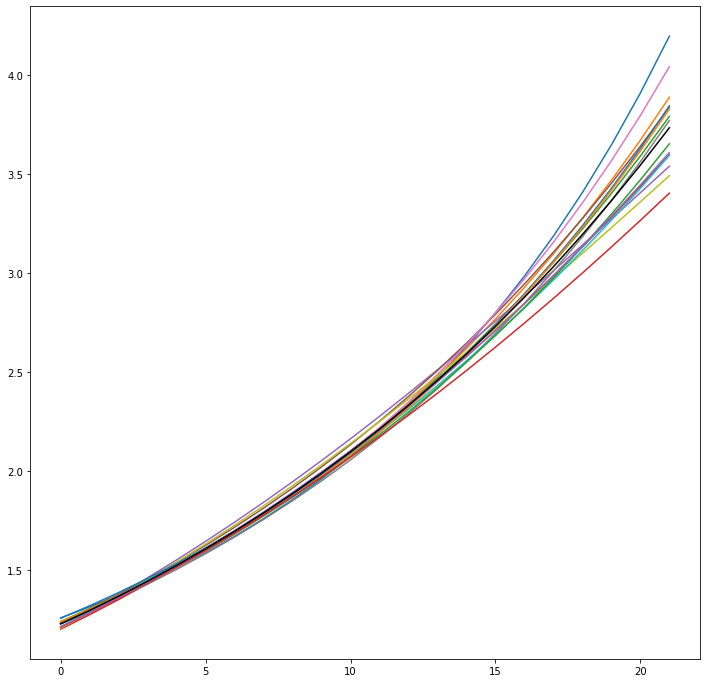

In [58]:
plt.figure(figsize = (12, 12))
z = np.linspace(0.025, 1.025, 22)
for i in range(15):
    plt.plot(mass_coefficient(js[i], ks[i], ls[i], z))
plt.plot(mass_coefficient(j_avg, k_avg, l_avg, z), "-k")
plt.show()

In [44]:
j_avg, k_avg, l_avg = (np.mean(js), np.mean(ks), np.mean(ls))

In [59]:
print(j_avg, k_avg, l_avg)

-0.010062146327355921 0.4931848214696567 0.07716204385814744


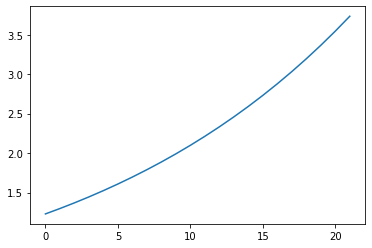

In [45]:
z = np.linspace(0.025, 1.025, 22)
plt.plot(mass_coefficient(j_avg, k_avg, l_avg, z))
plt.show()

In [56]:
z2 = z.reshape((1, 22))
std_mass_coeff = np.std(10**(np.array(js).reshape((15, 1))*z**2 + np.array(ks).reshape((15, 1))*z + np.array(ls).reshape((15, 1))), axis = 0)

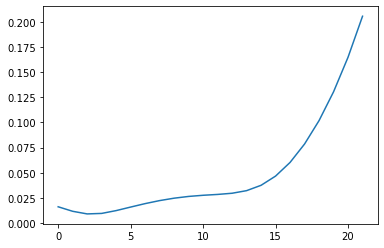

In [57]:
z = np.linspace(0.025, 1.025, 22)
plt.plot(std_mass_coeff)
plt.show()